<a href="https://colab.research.google.com/github/afonsoegmar/Rede_Neural/blob/main/Rede_Neural_Multilayer_Perceptron_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
dados = sklearn.datasets.load_iris()
# Imprimindo algumas informações sobre o conjunto de dados
print("Atributos:",dados['feature_names'])
print("Classes (labels):",dados['target_names'])
print("Dimensões:", dados['data'].shape)
df = pd.DataFrame(dados.data, columns = dados.feature_names)
df['label'] = [dados.target_names[i] for i in dados.target]

Atributos: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes (labels): ['setosa' 'versicolor' 'virginica']
Dimensões: (150, 4)


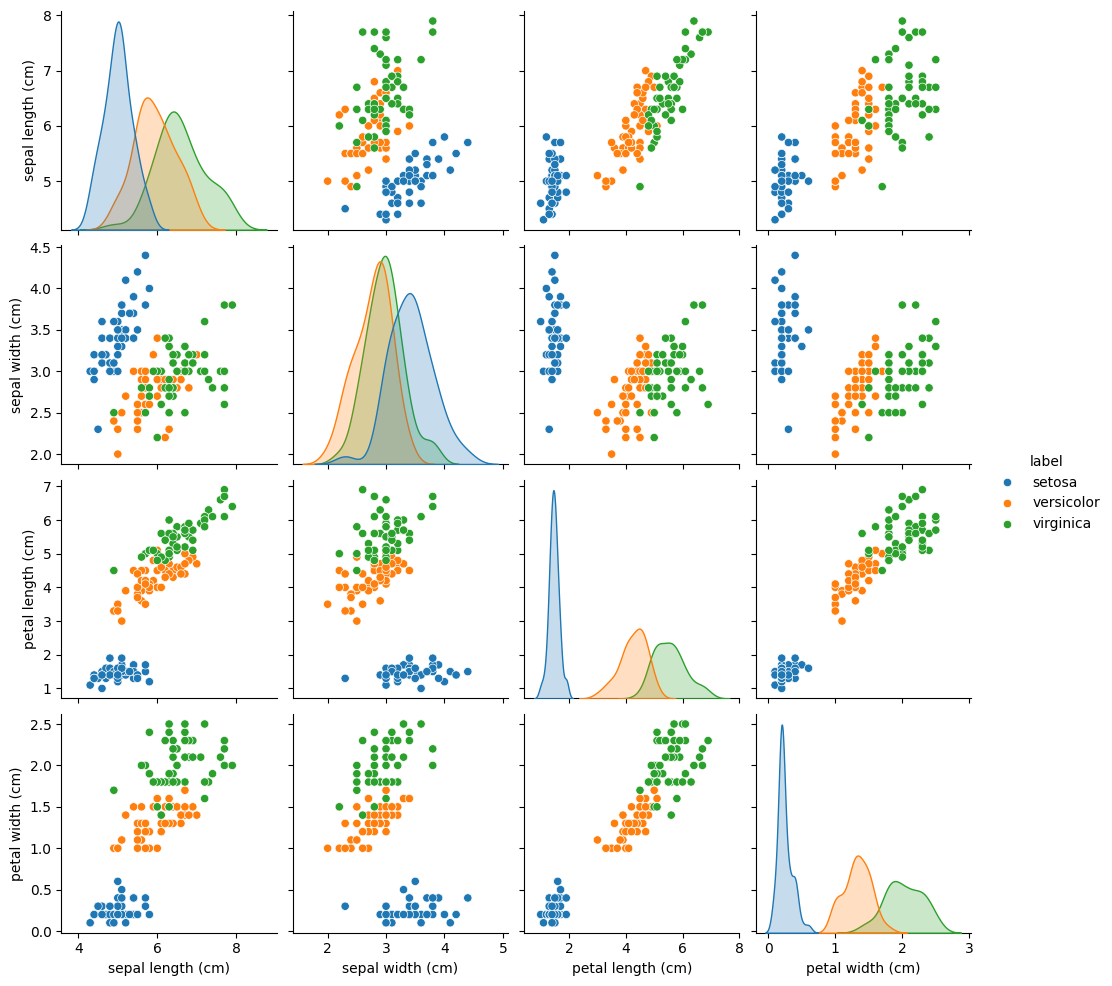

In [ ]:
# Pair Plot
sns.pairplot(df, hue = 'label')

In [ ]:
X = df.drop(['label'], axis=1)
# Normalização dos dados (Min-Max)
normalizador = MinMaxScaler()
X_norm = pd.DataFrame(normalizador.fit_transform(X), columns=X.columns)
labels = df.label.unique()
print(labels)
#Transformação dos atributos (classes) categóricos em
# numéricos (1-de-c / one-hot-encoding)
# setosa -> 0 0 1
# versicolor -> 0 1 0
# virginica -> 1 0 0
Y = pd.get_dummies(df.label)
print(Y)


['setosa' 'versicolor' 'virginica']
     setosa  versicolor  virginica
0      True       False      False
1      True       False      False
2      True       False      False
3      True       False      False
4      True       False      False
..      ...         ...        ...
145   False       False       True
146   False       False       True
147   False       False       True
148   False       False       True
149   False       False       True

[150 rows x 3 columns]


In [ ]:
# Separação desenvolvimento (90) e teste (10)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_norm, Y, test_size=0.1, random_state=1)
# Separação treino (80) e validação (20)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(108, 4)
(27, 4)
(15, 4)


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):  # Corrigido aqui
        super(MLP, self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.Tanh(),
            nn.Linear(10, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.rede(x)
        return out


In [ ]:
input_dim = 4 # número de atributos do Iris
output_dim = 3 # número de classes
modelo = MLP(input_dim,output_dim) # Criação do modelo (rede)


In [ ]:
from torchsummary import summary
print(modelo)
summary(modelo, (150,4))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=3, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 10]              50
              Tanh-2              [-1, 150, 10]               0
            Linear-3               [-1, 150, 3]              33
           Sigmoid-4               [-1, 150, 3]               0
Total params: 83
Trainable params: 83
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [ ]:
eta = 0.2
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(modelo.parameters(),lr=eta)

In [ ]:
x_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(Y_train.values)
x_val = torch.FloatTensor(X_val.values)
y_val = torch.FloatTensor(Y_val.values)
x_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(Y_test.values)

In [ ]:
# verificando disponibilidade da gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def train_network(model, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_losses):
    for epoch in range(num_epochs):
        # zerando os gradientes da época anterior
        optimizer.zero_grad()
        # fase de propagação
        output_train = model(x_train)
        # cálculo do erro (função de custo - loss function)
        loss_train = loss_function(output_train, y_train)
        # fase de retroprogação
        loss_train.backward()
        # atualização dos pesos da rede
        optimizer.step()
        # avaliando o modelo com o conjunto de validação
        output_val = model(x_val)
        loss_val = loss_function(output_val, y_val)

        train_losses[epoch] = loss_train.item()
        val_losses[epoch] = loss_val.item()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Erro Treino: {loss_train.item():.4f}, Erro Validação: {loss_val.item():.4f}")


In [ ]:
num_epochs = 5000
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_network(modelo, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_losses)


Epoch 100/5000, Erro Treino: 0.1922, Erro Validação: 0.2033
Epoch 200/5000, Erro Treino: 0.1577, Erro Validação: 0.1614
Epoch 300/5000, Erro Treino: 0.1327, Erro Validação: 0.1312
Epoch 400/5000, Erro Treino: 0.1204, Erro Validação: 0.1163
Epoch 500/5000, Erro Treino: 0.1134, Erro Validação: 0.1079
Epoch 600/5000, Erro Treino: 0.1084, Erro Validação: 0.1021
Epoch 700/5000, Erro Treino: 0.1041, Erro Validação: 0.0974
Epoch 800/5000, Erro Treino: 0.1002, Erro Validação: 0.0932
Epoch 900/5000, Erro Treino: 0.0965, Erro Validação: 0.0892
Epoch 1000/5000, Erro Treino: 0.0927, Erro Validação: 0.0853
Epoch 1100/5000, Erro Treino: 0.0890, Erro Validação: 0.0813
Epoch 1200/5000, Erro Treino: 0.0851, Erro Validação: 0.0773
Epoch 1300/5000, Erro Treino: 0.0812, Erro Validação: 0.0732
Epoch 1400/5000, Erro Treino: 0.0772, Erro Validação: 0.0690
Epoch 1500/5000, Erro Treino: 0.0732, Erro Validação: 0.0648
Epoch 1600/5000, Erro Treino: 0.0693, Erro Validação: 0.0606
Epoch 1700/5000, Erro Treino: 0.0

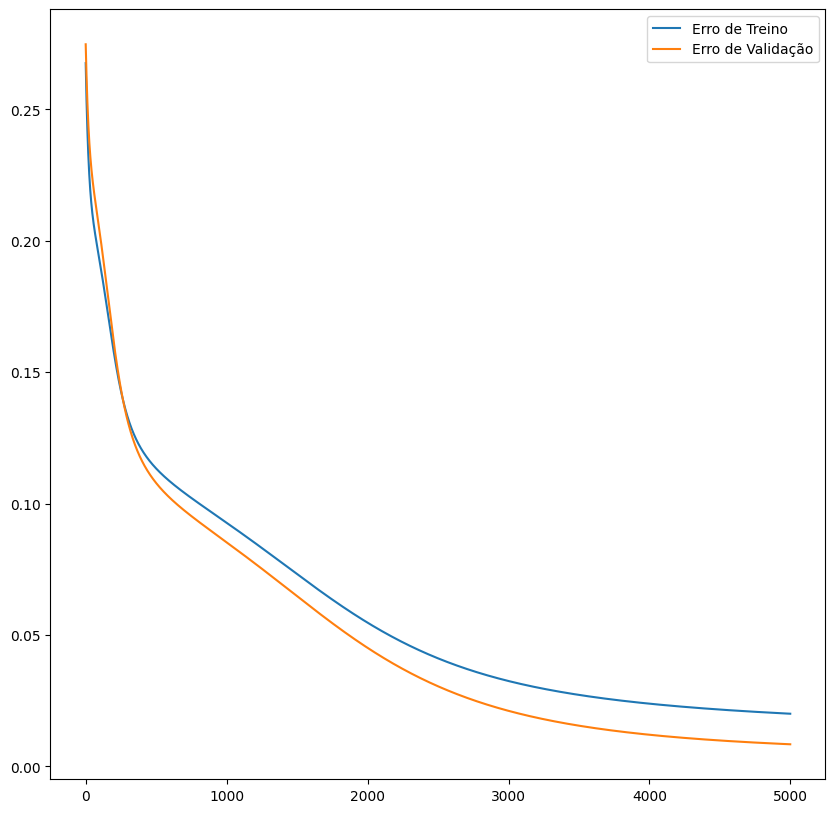

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Erro de Treino')
plt.plot(val_losses, label='Erro de Validação')
plt.legend()
plt.show()


In [ ]:
predictions_train = []
predictions_val = []
predictions_test = []
with torch.no_grad():
  predictions_train = modelo(x_train)
  predictions_val = modelo(x_val)
  predictions_test = modelo(x_test)
# Cálculo do erro (Função de Custo)
erro_train = loss_function(predictions_train,y_train)
erro_val = loss_function(predictions_val,y_val)
erro_test = loss_function(predictions_test,y_test)
print(f"Erro de Treino: {erro_train}")
print(f"Erro de Validação: {erro_val}")
print(f"Erro de Teste: {erro_test}")

Erro de Treino: 0.02005084604024887
Erro de Validação: 0.008428567089140415
Erro de Teste: 0.007390272803604603


In [ ]:
# Cálculo da Acurácia de Classificação:
pred_train = torch.argmax(predictions_train, dim=1)
label_train = torch.argmax(y_train, dim=1)
pred_val = torch.argmax(predictions_val, dim=1)
label_val = torch.argmax(y_val, dim=1)
pred_test = torch.argmax(predictions_test, dim=1)
label_test = torch.argmax(y_test, dim=1)
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(label_train, pred_train)
acc_val = accuracy_score(label_val, pred_val)
acc_test = accuracy_score(label_test, pred_test)
print(f"Acurácia de Treino: {acc_train*100:.2f}%")
print(f"Acurácia de Validação: {acc_val*100:.2f}%")
print(f"Acurácia de Teste: {acc_test*100:.2f}%")

Acurácia de Treino: 97.22%
Acurácia de Validação: 100.00%
Acurácia de Teste: 100.00%


Problema XOR